In [3]:
# Here are some imports that are used along this notebook
import os
import math
import itertools
import multiprocessing
import pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from collections import OrderedDict
%matplotlib inline
gt0 = time()

In [4]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, Row

In [5]:
conf = SparkConf()\
    .setMaster(f"local[{multiprocessing.cpu_count()}]")\
    .setAppName("PySpark NSL-KDD")\
    .setAll([("spark.driver.memory", "8g"), ("spark.default.parallelism", f"{multiprocessing.cpu_count()}")])

# Creating local SparkContext with specified SparkConf and creating SQLContext based on it
sc = SparkContext.getOrCreate(conf=conf)
sc.setLogLevel('INFO')
sqlContext = SQLContext(sc)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/13 13:12:07 WARN Utils: Your hostname, Adityas-MacBook-Pro-4.local, resolves to a loopback address: 127.0.0.1; using 192.0.0.2 instead (on interface en0)
25/11/13 13:12:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/13 13:12:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/11/13 13:12:08 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
/Users/adityalanka/miniforge3/lib/python3.12/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [6]:
from pyspark.sql.types import *
from pyspark.sql.functions import udf, split, col
import pyspark.sql.functions as sql

train20_nsl_kdd_dataset_path = os.path.join("NSL_KDD_Dataset", "KDDTrain+_20Percent.txt")
train_nsl_kdd_dataset_path = os.path.join("NSL_KDD_Dataset", "KDDTrain+.txt")
test_nsl_kdd_dataset_path = os.path.join("NSL_KDD_Dataset", "KDDTest+.txt")

col_names = np.array(["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","labels"])

nominal_inx = [1, 2, 3]
binary_inx = [6, 11, 13, 14, 20, 21]
numeric_inx = list(set(range(41)).difference(nominal_inx).difference(binary_inx))

nominal_cols = col_names[nominal_inx].tolist()
binary_cols = col_names[binary_inx].tolist()
numeric_cols = col_names[numeric_inx].tolist()

In [7]:
# Function to load dataset and divide it into 8 partitions
def load_dataset(path):
    dataset_rdd = sc.textFile(path, 8).map(lambda line: line.split(','))
    dataset_df = (dataset_rdd.toDF(col_names.tolist()).select(
                    col('duration').cast(DoubleType()),
                    col('protocol_type').cast(StringType()),
                    col('service').cast(StringType()),
                    col('flag').cast(StringType()),
                    col('src_bytes').cast(DoubleType()),
                    col('dst_bytes').cast(DoubleType()),
                    col('land').cast(DoubleType()),
                    col('wrong_fragment').cast(DoubleType()),
                    col('urgent').cast(DoubleType()),
                    col('hot').cast(DoubleType()),
                    col('num_failed_logins').cast(DoubleType()),
                    col('logged_in').cast(DoubleType()),
                    col('num_compromised').cast(DoubleType()),
                    col('root_shell').cast(DoubleType()),
                    col('su_attempted').cast(DoubleType()),
                    col('num_root').cast(DoubleType()),
                    col('num_file_creations').cast(DoubleType()),
                    col('num_shells').cast(DoubleType()),
                    col('num_access_files').cast(DoubleType()),
                    col('num_outbound_cmds').cast(DoubleType()),
                    col('is_host_login').cast(DoubleType()),
                    col('is_guest_login').cast(DoubleType()),
                    col('count').cast(DoubleType()),
                    col('srv_count').cast(DoubleType()),
                    col('serror_rate').cast(DoubleType()),
                    col('srv_serror_rate').cast(DoubleType()),
                    col('rerror_rate').cast(DoubleType()),
                    col('srv_rerror_rate').cast(DoubleType()),
                    col('same_srv_rate').cast(DoubleType()),
                    col('diff_srv_rate').cast(DoubleType()),
                    col('srv_diff_host_rate').cast(DoubleType()),
                    col('dst_host_count').cast(DoubleType()),
                    col('dst_host_srv_count').cast(DoubleType()),
                    col('dst_host_same_srv_rate').cast(DoubleType()),
                    col('dst_host_diff_srv_rate').cast(DoubleType()),
                    col('dst_host_same_src_port_rate').cast(DoubleType()),
                    col('dst_host_srv_diff_host_rate').cast(DoubleType()),
                    col('dst_host_serror_rate').cast(DoubleType()),
                    col('dst_host_srv_serror_rate').cast(DoubleType()),
                    col('dst_host_rerror_rate').cast(DoubleType()),
                    col('dst_host_srv_rerror_rate').cast(DoubleType()),
                    col('labels').cast(StringType())))

    return dataset_df

In [8]:
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import StringIndexer
from pyspark import keyword_only
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param

# Dictionary that contains mapping of various attacks to the four main categories
attack_dict = {
    'normal': 'normal',
    
    'back': 'DoS',
    'land': 'DoS',
    'neptune': 'DoS',
    'pod': 'DoS',
    'smurf': 'DoS',
    'teardrop': 'DoS',
    'mailbomb': 'DoS',
    'apache2': 'DoS',
    'processtable': 'DoS',
    'udpstorm': 'DoS',
    
    'ipsweep': 'Probe',
    'nmap': 'Probe',
    'portsweep': 'Probe',
    'satan': 'Probe',
    'mscan': 'Probe',
    'saint': 'Probe',

    'ftp_write': 'R2L',
    'guess_passwd': 'R2L',
    'imap': 'R2L',
    'multihop': 'R2L',
    'phf': 'R2L',
    'spy': 'R2L',
    'warezclient': 'R2L',
    'warezmaster': 'R2L',
    'sendmail': 'R2L',
    'named': 'R2L',
    'snmpgetattack': 'R2L',
    'snmpguess': 'R2L',
    'xlock': 'R2L',
    'xsnoop': 'R2L',
    'worm': 'R2L',
    
    'buffer_overflow': 'U2R',
    'loadmodule': 'U2R',
    'perl': 'U2R',
    'rootkit': 'U2R',
    'httptunnel': 'U2R',
    'ps': 'U2R',    
    'sqlattack': 'U2R',
    'xterm': 'U2R'
}

attack_mapping_udf = udf(lambda v: attack_dict[v])

class Labels2Converter(Transformer):

    @keyword_only
    def __init__(self):
        super(Labels2Converter, self).__init__()

    def _transform(self, dataset):
        return dataset.withColumn('labels2', sql.regexp_replace(col('labels'), '^(?!normal).*$', 'attack'))
     
class Labels5Converter(Transformer):
    
    @keyword_only
    def __init__(self):
        super(Labels5Converter, self).__init__()

    def _transform(self, dataset):
        return dataset.withColumn('labels5', attack_mapping_udf(col('labels')))
    
labels2_indexer = StringIndexer(inputCol="labels2", outputCol="labels2_index")
labels5_indexer = StringIndexer(inputCol="labels5", outputCol="labels5_index")

labels_mapping_pipeline = Pipeline(stages=[Labels2Converter(), Labels5Converter(), labels2_indexer, labels5_indexer])

labels2 = ['normal', 'attack']
labels5 = ['normal', 'DoS', 'Probe', 'R2L', 'U2R']
labels_col = 'labels2_index'

In [9]:




# Loading train data

t0 = time()
train_nsl_kdd_dataset_path = "file:///Users/adityalanka/Desktop/cn/nsl-kdd/NSL_KDD_Dataset/KDDTrain+.txt"
train_df = load_dataset(train_nsl_kdd_dataset_path)




# Fitting preparation pipeline
labels_mapping_model = labels_mapping_pipeline.fit(train_df)

# Transforming labels column and adding id column
train_df = labels_mapping_model.transform(train_df).withColumn('id', sql.monotonically_increasing_id())

train_df = train_df.cache()
print(f"Number of examples in train set: {train_df.count()}")
print(f"Time: {time() - t0:.2f}s")

25/11/13 13:12:11 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Number of examples in train set: 125973
Time: 4.89s


In [10]:
# Loading test data
t0 = time()
test_nsl_kdd_dataset_path = "file:///Users/adityalanka/Desktop/cn/nsl-kdd/NSL_KDD_Dataset/KDDTest+.txt"
test_df = load_dataset(test_nsl_kdd_dataset_path)

# Transforming labels column and adding id column
test_df = labels_mapping_model.transform(test_df).withColumn('id', sql.monotonically_increasing_id())

test_df = test_df.cache()
print(f"Number of examples in test set: {test_df.count()}")
print(f"Time: {time() - t0:.2f}s")

Number of examples in test set: 22544
Time: 0.50s


In [11]:
# Labels columns
(train_df.groupby('labels2').count().show())
(train_df.groupby('labels5').count().sort(sql.desc('count')).show())

+-------+-----+
|labels2|count|
+-------+-----+
| normal|67343|
| attack|58630|
+-------+-----+

+-------+-----+
|labels5|count|
+-------+-----+
| normal|67343|
|    DoS|45927|
|  Probe|11656|
|    R2L|  995|
|    U2R|   52|
+-------+-----+



In [12]:
(test_df.groupby('labels2').count().show())
(test_df.groupby('labels5').count().sort(sql.desc('count')).show())

+-------+-----+
|labels2|count|
+-------+-----+
| normal| 9711|
| attack|12833|
+-------+-----+

+-------+-----+
|labels5|count|
+-------+-----+
| normal| 9711|
|    DoS| 7458|
|    R2L| 2754|
|  Probe| 2421|
|    U2R|  200|
+-------+-----+



In [13]:
# 'protocol_type' nominal column
(train_df.crosstab(nominal_cols[0], 'labels2').sort(sql.asc(nominal_cols[0] + '_labels2')).show())
(train_df.crosstab(nominal_cols[0], 'labels5').sort(sql.asc(nominal_cols[0] + '_labels5')).show())

+---------------------+------+------+
|protocol_type_labels2|attack|normal|
+---------------------+------+------+
|                 icmp|  6982|  1309|
|                  tcp| 49089| 53600|
|                  udp|  2559| 12434|
+---------------------+------+------+

+---------------------+-----+-----+---+---+------+
|protocol_type_labels5|  DoS|Probe|R2L|U2R|normal|
+---------------------+-----+-----+---+---+------+
|                 icmp| 2847| 4135|  0|  0|  1309|
|                  tcp|42188| 5857|995| 49| 53600|
|                  udp|  892| 1664|  0|  3| 12434|
+---------------------+-----+-----+---+---+------+



In [14]:
# 'service' nominal column
print(train_df.select(nominal_cols[1]).distinct().count())
(train_df.crosstab(nominal_cols[1], 'labels2').sort(sql.asc(nominal_cols[1] + '_labels2')).show(n=70))
(train_df.crosstab(nominal_cols[1], 'labels5').sort(sql.asc(nominal_cols[1] + '_labels5')).show(n=70))

70
+---------------+------+------+
|service_labels2|attack|normal|
+---------------+------+------+
|            IRC|     1|   186|
|            X11|     6|    67|
|         Z39_50|   862|     0|
|            aol|     2|     0|
|           auth|   719|   236|
|            bgp|   710|     0|
|        courier|   734|     0|
|       csnet_ns|   545|     0|
|            ctf|   563|     0|
|        daytime|   521|     0|
|        discard|   538|     0|
|         domain|   531|    38|
|       domain_u|     9|  9034|
|           echo|   434|     0|
|          eco_i|  4089|   497|
|          ecr_i|  2887|   190|
|            efs|   485|     0|
|           exec|   474|     0|
|         finger|  1222|   545|
|            ftp|   836|   918|
|       ftp_data|  1876|  4984|
|         gopher|   518|     0|
|        harvest|     2|     0|
|      hostnames|   460|     0|
|           http|  2289| 38049|
|      http_2784|     1|     0|
|       http_443|   530|     0|
|      http_8001|     2|     0|
|    

In [15]:
# 'flag' nominal column
print(train_df.select(nominal_cols[2]).distinct().count())
(train_df.crosstab(nominal_cols[2], 'labels2').sort(sql.asc(nominal_cols[2] + '_labels2')).show())
(train_df.crosstab(nominal_cols[2], 'labels5').sort(sql.asc(nominal_cols[2] + '_labels5')).show())

11
+------------+------+------+
|flag_labels2|attack|normal|
+------------+------+------+
|         OTH|    35|    11|
|         REJ|  8540|  2693|
|        RSTO|  1343|   219|
|      RSTOS0|   103|     0|
|        RSTR|  2275|   146|
|          S0| 34497|   354|
|          S1|     4|   361|
|          S2|     8|   119|
|          S3|     4|    45|
|          SF| 11552| 63393|
|          SH|   269|     2|
+------------+------+------+

+------------+-----+-----+---+---+------+
|flag_labels5|  DoS|Probe|R2L|U2R|normal|
+------------+-----+-----+---+---+------+
|         OTH|    0|   35|  0|  0|    11|
|         REJ| 5671| 2869|  0|  0|  2693|
|        RSTO| 1216|   80| 46|  1|   219|
|      RSTOS0|    0|  103|  0|  0|     0|
|        RSTR|   90| 2180|  5|  0|   146|
|          S0|34344|  153|  0|  0|   354|
|          S1|    2|    1|  1|  0|   361|
|          S2|    5|    2|  1|  0|   119|
|          S3|    0|    1|  3|  0|    45|
|          SF| 4599| 5967|935| 51| 63393|
|          SH| 

In [16]:
# Binary columns
(train_df.select(binary_cols).describe().toPandas().transpose())

,0,1,2,3,4
summary,count,mean,stddev,min,max
land,125973,1.9845522453224102E-4,0.014086071671513094,0.0,1.0
logged_in,125973,0.3957355941352512,0.48901005300524175,0.0,1.0
root_shell,125973,0.0013415573178379495,0.03660284383979861,0.0,1.0
su_attempted,125973,0.0011034110483992602,0.04515438381386557,0.0,2.0
is_host_login,125973,7.938208981289641E-6,0.0028174827384191085,0.0,1.0
is_guest_login,125973,0.009422654060790804,0.09661232709143104,0.0,1.0


In [17]:
# 'su_attempted' should be a binary feature, but has 3 values
(train_df.crosstab('su_attempted', 'labels2').show())

+--------------------+------+------+
|su_attempted_labels2|attack|normal|
+--------------------+------+------+
|                 1.0|     1|    20|
|                 0.0| 58629| 67264|
|                 2.0|     0|    59|
+--------------------+------+------+



In [18]:
# '2.0' value is replaced to '0.0' for both train and test datasets
train_df = train_df.replace(2.0, 0.0, 'su_attempted')
test_df = test_df.replace(2.0, 0.0, 'su_attempted')

In [19]:
# Numeric columns
print(len(numeric_cols))
(train_df.select(numeric_cols).describe().toPandas().transpose())

32


,0,1,2,3,4
summary,count,mean,stddev,min,max
duration,125973,287.1446500440571,2604.515309867592,0.0,42908.0
src_bytes,125973,45566.74300048423,5870331.181893551,0.0,1.379963888E9
dst_bytes,125973,19779.114421344257,4021269.1514414474,0.0,1.309937401E9
wrong_fragment,125973,0.022687401268525795,0.25352998595201254,0.0,3.0
urgent,125973,1.1113492573805498E-4,0.014366026620154243,0.0,3.0
hot,125973,0.20440888126820828,2.1499684337047587,0.0,77.0
num_failed_logins,125973,0.0012224841831186047,0.045239138981329835,0.0,5.0
num_compromised,125973,0.279250315543807,23.942042242795125,0.0,7479.0
num_root,125973,0.30219173949973405,24.3996180888374,0.0,7468.0


In [20]:
(train_df.crosstab('num_outbound_cmds', 'labels2').show())

+-------------------------+------+------+
|num_outbound_cmds_labels2|attack|normal|
+-------------------------+------+------+
|                      0.0| 58630| 67343|
+-------------------------+------+------+



In [21]:
train_df = train_df.drop('num_outbound_cmds')
test_df = test_df.drop('num_outbound_cmds')
numeric_cols.remove('num_outbound_cmds')

In [22]:
def ohe_vec(cat_dict, row):
    vec = np.zeros(len(cat_dict))
    vec[cat_dict[row]] = float(1.0)
    return vec.tolist()

def ohe(df, nominal_col):
    categories = (df.select(nominal_col)
                    .distinct()
                    .rdd.map(lambda row: row[0])
                    .collect())
    
    cat_dict = dict(zip(categories, range(len(categories))))
    
    udf_ohe_vec = udf(lambda row: ohe_vec(cat_dict, row), 
                      StructType([StructField(cat, DoubleType(), False) for cat in categories]))
    
    df = df.withColumn(nominal_col + '_ohe', udf_ohe_vec(col(nominal_col))).cache()
    
    nested_cols = [nominal_col + '_ohe.' + cat for cat in categories]
    ohe_cols = [nominal_col + '_' + cat for cat in categories]
        
    for new, old in zip(ohe_cols, nested_cols):
        df = df.withColumn(new, col(old))

    df = df.drop(nominal_col + '_ohe')
                   
    return df, ohe_cols

In [23]:
t0 = time()
train_ohe_cols = []

train_df, train_ohe_col0 = ohe(train_df, nominal_cols[0])
train_ohe_cols += train_ohe_col0

train_df, train_ohe_col1 = ohe(train_df, nominal_cols[1])
train_ohe_cols += train_ohe_col1

train_df, train_ohe_col2 = ohe(train_df, nominal_cols[2])
train_ohe_cols += train_ohe_col2

binary_cols += train_ohe_cols

train_df = train_df.cache()
print(f"Number of examples in train set: {train_df.count()}")
print(f"Time: {time() - t0:.2f}s")

Number of examples in train set: 125973
Time: 1.99s


In [24]:
t0 = time()
test_ohe_cols = []

test_df, test_ohe_col0_names = ohe(test_df, nominal_cols[0])
test_ohe_cols += test_ohe_col0_names

test_df, test_ohe_col1_names = ohe(test_df, nominal_cols[1])
test_ohe_cols += test_ohe_col1_names

test_df, test_ohe_col2_names = ohe(test_df, nominal_cols[2])
test_ohe_cols += test_ohe_col2_names

test_binary_cols = col_names[binary_inx].tolist() + test_ohe_cols

test_df = test_df.cache()
print(f"Number of examples in test set: {test_df.count()}")
print(f"Time: {time() - t0:.2f}s")

Number of examples in test set: 22544
Time: 0.96s


In [25]:
from collections import OrderedDict
from pyspark.sql import functions as sql
from pyspark.sql.functions import col

def getAttributeRatio(df, numericCols, binaryCols, labelCol):
    ratio_dict = {}
    
    # --- numeric columns ---
    if numericCols:
        avg_dict = (
            df.select([sql.avg(c).alias(c) for c in numericCols])
              .first()
              .asDict()
        )

        ratio_dict.update(
            df.groupBy(labelCol)
              .avg(*numericCols)
              .select([
                  sql.max(col(f"avg({c})") / avg_dict[c]).alias(c)
                  for c in numericCols
              ])
              .fillna(0.0)
              .first()
              .asDict()
        )

    # --- binary columns ---
    if binaryCols:
        ratio_dict.update(
            df.groupBy(labelCol)
              .agg(*[
                  # Use try_divide safely (Spark 3.4+) or fallback to when/otherwise
                  sql.try_divide(
                      sql.sum(col(c)),
                      (sql.count(col(c)) - sql.sum(col(c)))
                  ).alias(c)
                  for c in binaryCols
              ])
              .fillna(1000.0)
              .select([sql.max(col(c)).alias(c) for c in binaryCols])
              .first()
              .asDict()
        )

    # --- sort descending by AR value ---
    return OrderedDict(sorted(ratio_dict.items(), key=lambda v: -v[1]))

def selectFeaturesByAR(ar_dict, min_ar):
    return [f for f in ar_dict.keys() if ar_dict[f] >= min_ar]


In [26]:
t0 = time()
ar_dict = getAttributeRatio(train_df, numeric_cols, binary_cols, 'labels5')

print(f"Number of features in Attribute Ration dict: {len(ar_dict)}")
print(f"Time: {time() - t0:.2f}s")
ar_dict

Number of features in Attribute Ration dict: 121
Time: 1.53s


OrderedDict([('protocol_type_tcp', 1000.0),
             ('num_shells', 326.11353550295854),
             ('urgent', 173.03983516483518),
             ('num_file_creations', 62.23362492770388),
             ('flag_SF', 51.0),
             ('num_failed_logins', 46.03855641845592),
             ('hot', 40.77451681709518),
             ('logged_in', 10.569767441860465),
             ('dst_bytes', 9.154854355343401),
             ('src_bytes', 8.464064204948945),
             ('duration', 7.225829157212557),
             ('dst_host_srv_diff_host_rate', 5.756880682756574),
             ('dst_host_diff_srv_rate', 4.83734184897426),
             ('num_access_files', 4.694879248658319),
             ('dst_host_same_src_port_rate', 4.393080378884017),
             ('num_compromised', 4.338539274983927),
             ('diff_srv_rate', 4.069085485070395),
             ('dst_host_srv_rerror_rate', 3.667920527965924),
             ('srv_rerror_rate', 3.667741802325429),
             ('rerror_rate',

In [27]:
t0 = time()
avg_dict = (train_df.select(list(map(lambda c: sql.avg(c).alias(c), numeric_cols))).first().asDict())
std_dict = (train_df.select(list(map(lambda c: sql.stddev(c).alias(c), numeric_cols))).first().asDict())

def standardizer(column):
    return ((col(column) - avg_dict[column])/std_dict[column]).alias(column)

# Standardizer without mean
# def standardizer(column):
#     return (col(column)/std_dict[column]).alias(column)

train_scaler = [*binary_cols, *list(map(standardizer, numeric_cols)), *['id', 'labels2_index', 'labels2', 'labels5_index', 'labels5']]
test_scaler = [*test_binary_cols, *list(map(standardizer, numeric_cols)), *['id', 'labels2_index', 'labels2', 'labels5_index', 'labels5']]

scaled_train_df = (train_df.select(train_scaler).cache())
scaled_test_df = (test_df.select(test_scaler).cache())

print(scaled_train_df.count())
print(scaled_test_df.count())
print(f"Time: {time() - t0:.2f}s")

125973
22544
Time: 0.82s


In [28]:
from pyspark.ml.feature import VectorIndexer, VectorAssembler
assembler = VectorAssembler(inputCols=selectFeaturesByAR(ar_dict, 0.01), outputCol='raw_features')
indexer = VectorIndexer(inputCol='raw_features', outputCol='indexed_features', maxCategories=2)

prep_pipeline = Pipeline(stages=[assembler, indexer])
prep_model = prep_pipeline.fit(scaled_train_df)

In [29]:
t0 = time()
scaled_train_df = (prep_model
        .transform(scaled_train_df)
        .select('id', 'indexed_features', 'labels2_index', 'labels2', 'labels5_index', 'labels5')
        .cache())

scaled_test_df = (prep_model 
        .transform(scaled_test_df)
        .select('id', 'indexed_features','labels2_index', 'labels2', 'labels5_index', 'labels5')
        .cache())

print(scaled_train_df.count())
print(scaled_test_df.count())
print(f"Time: {time() - t0:.2f}s")

125973
22544
Time: 0.45s


In [30]:
# Setting seed for reproducibility
seed = 4667979835606274383
print(seed)

4667979835606274383


In [31]:
split = (scaled_train_df.randomSplit([0.8, 0.2], seed=seed))

scaled_train_df = split[0].cache()
scaled_cv_df = split[1].cache()

print(scaled_train_df.count())
print(scaled_cv_df.count())

100828
25145


In [32]:
res_cv_df = scaled_cv_df.select(col('id'), col('labels2_index'), col('labels2'), col('labels5')).cache()
res_test_df = scaled_test_df.select(col('id'), col('labels2_index'), col('labels2'), col('labels5')).cache()
prob_cols = []
pred_cols = []

print(res_cv_df.count())
print(res_test_df.count())

25145
22544


In [33]:
import sklearn.metrics as metrics

def printCM(cm, labels):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels])
    # Print header
    print(" " * columnwidth, end="\t")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end="\t")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("%{0}s".format(columnwidth) % label1, end="\t")
        for j in range(len(labels)):
            print("%{0}d".format(columnwidth) % cm[i, j], end="\t")
        print()

def getPrediction(e):
    return udf(lambda row: 1.0 if row >= e else 0.0, DoubleType())
        
def printReport(resDF, probCol, labelCol='labels2_index', e=None, labels=['normal', 'attack']):
    if (e):
        predictionAndLabels = list(zip(*resDF.rdd
                                       .map(lambda row: (1.0 if row[probCol] >= e else 0.0, row[labelCol]))
                                       .collect()))
    else:
        predictionAndLabels = list(zip(*resDF.rdd
                                       .map(lambda row: (row[probCol], row[labelCol]))
                                       .collect()))
    
    cm = metrics.confusion_matrix(predictionAndLabels[1], predictionAndLabels[0])
    printCM(cm, labels)
    print(" ")
    print("Accuracy = %g" % (metrics.accuracy_score(predictionAndLabels[1], predictionAndLabels[0])))
    print("AUC = %g" % (metrics.roc_auc_score(predictionAndLabels[1], predictionAndLabels[0])))
    print(" ")
    print("False Alarm Rate = %g" % (cm[0][1]/(cm[0][0] + cm[0][1])))
    print("Detection Rate = %g" % (cm[1][1]/(cm[1][1] + cm[1][0])))
    print("F1 score = %g" % (metrics.f1_score(predictionAndLabels[1], predictionAndLabels[0], labels)))
    print(" ")
    print(metrics.classification_report(predictionAndLabels[1], predictionAndLabels[0]))
    print(" ")

In [34]:
# =========================================================
# PURE MULTI-ARMED BANDIT PIPELINE (THOMPSON SAMPLING)
# =========================================================

from pyspark.sql.functions import col, when, lit, udf
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorSlicer
from pyspark.sql import SparkSession
import numpy as np
from numpy.random import beta
from time import time
import pandas as pd
from sklearn import metrics

spark = SparkSession.builder.getOrCreate()

# ---------------------------------------------------------
# 1️⃣ Thompson Sampling Bandit Class
# ---------------------------------------------------------
class BanditThompson:
    """Thompson Sampling Multi-Armed Bandit."""
    def __init__(self, n_arms=None):
        self.n_arms = n_arms
        self.success = None
        self.failure = None

    def fit(self, arms, rewards):
        """Train Bandit model on arms and binary rewards."""
        if self.n_arms is None:
            self.n_arms = int(np.max(arms)) + 1
        self.success = np.zeros(self.n_arms)
        self.failure = np.zeros(self.n_arms)
        for arm, reward in zip(arms, rewards):
            if reward == 1:
                self.success[int(arm)] += 1
            else:
                self.failure[int(arm)] += 1

    def predict_prob(self, arm):
        """Expected success probability for arm."""
        arm = arm % self.n_arms
        return (self.success[arm] + 1) / (self.success[arm] + self.failure[arm] + 2)


# ---------------------------------------------------------
# 2️⃣ Train Bandit Model
# ---------------------------------------------------------
def trainBanditModel(df, ar_dict, numeric_cols):
    print("\n=== Training Bandit Model ===")
    t0 = time()

    # Label to binary reward
    df = df.withColumn("reward", when(col("labels2") == "normal", lit(1)).otherwise(lit(0)))

    slicer = VectorSlicer(
        inputCol="indexed_features",
        outputCol="bandit_features",
        names=list(set(selectFeaturesByAR(ar_dict, 0.05)).intersection(numeric_cols))
    )

    pdf = slicer.transform(df).select("id", "bandit_features", "reward").toPandas()
    if pdf.empty:
        raise ValueError("No data found for Bandit training!")

    # Create arm ID per row (deterministic hash)
    pdf["arm"] = [hash(tuple(x)) % 25 for x in pdf["bandit_features"]]
    arms = pdf["arm"].astype(int).values
    rewards = pdf["reward"].astype(int).values

    # Train Bandit
    bandit = BanditThompson(n_arms=len(np.unique(arms)))
    bandit.fit(arms, rewards)

    print(f"✅ Trained Bandit with {bandit.n_arms} arms in {time() - t0:.2f}s")
    return bandit


# ---------------------------------------------------------
# 3️⃣ Generate Predictions for New Data
# ---------------------------------------------------------
def getBanditProbabilities(df, bandit, ar_dict, numeric_cols, probCol="bandit_prob"):
    slicer = VectorSlicer(
        inputCol="indexed_features",
        outputCol="bandit_features",
        names=list(set(selectFeaturesByAR(ar_dict, 0.05)).intersection(numeric_cols))
    )

    pdf = slicer.transform(df).select("id", "bandit_features").toPandas()
    pdf["arm"] = [hash(tuple(x)) % bandit.n_arms for x in pdf["bandit_features"]]
    pdf[probCol] = [bandit.predict_prob(a) for a in pdf["arm"]]
    return spark.createDataFrame(pdf[["id", probCol]])


# ---------------------------------------------------------
# 4️⃣ Evaluate Bandit Model
# ---------------------------------------------------------
def evaluateBandit(bandit):
    total = np.sum(bandit.success + bandit.failure)
    avg_safe = np.sum(bandit.success) / total if total > 0 else 0
    print("\n=== Bandit Evaluation Summary ===")
    print(f"Arms trained            : {bandit.n_arms}")
    print(f"Average safe probability: {avg_safe:.4f}")
    return avg_safe


# ---------------------------------------------------------
# 5️⃣ Custom printReport() with Auto-Threshold + Fix
# ---------------------------------------------------------
def printReport(df, prob_col, labels=None):
    """Evaluate with sklearn metrics and auto-tune threshold for best F1."""
    print("\n=== MODEL PERFORMANCE REPORT ===")

    pdf = df.select(prob_col, "labels2").toPandas()
    pdf["true"] = (pdf["labels2"] == "normal").astype(int)
    y_true = pdf["true"].values
    y_prob = pdf[prob_col].values

    # Auto-optimize threshold for F1
    thresholds = np.linspace(0.1, 0.9, 17)
    best_f1, best_e = 0, 0.5
    for e in thresholds:
        y_pred = (y_prob > e).astype(int)
        f1 = metrics.f1_score(y_true, y_pred, zero_division=0)
        if f1 > best_f1:
            best_f1, best_e = f1, e

    print(f"Optimal threshold (e) = {best_e:.2f} | Best F1 = {best_f1:.4f}")

    # Final predictions
    pdf["pred"] = (y_prob > best_e).astype(int)
    y_pred = pdf["pred"].values

    acc = metrics.accuracy_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred, zero_division=0)
    rec = metrics.recall_score(y_true, y_pred, zero_division=0)
    f1 = metrics.f1_score(y_true, y_pred, zero_division=0)
    cm = metrics.confusion_matrix(y_true, y_pred)

    print(f"\nAccuracy  = {acc:.4f}")
    print(f"Precision = {prec:.4f}")
    print(f"Recall    = {rec:.4f}")
    print(f"F1 Score  = {f1:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nDetailed Report:")
    print(metrics.classification_report(
        y_true, y_pred, target_names=["attack", "normal"], zero_division=0
    ))


# ---------------------------------------------------------
# 6️⃣ FULL EXECUTION PIPELINE
# ---------------------------------------------------------
bandit_prob_col = "bandit_prob"

# Train Bandit
t0 = time()
bandit_model = trainBanditModel(scaled_train_df, ar_dict, numeric_cols)
print(f"Training time: {time() - t0:.2f}s")

# CV Set
t0 = time()
res_cv_df = (
    res_cv_df.drop(bandit_prob_col)
    .join(getBanditProbabilities(scaled_cv_df, bandit_model, ar_dict, numeric_cols, probCol=bandit_prob_col), "id")
    .cache()
)
print(f"CV count: {res_cv_df.count()} | Time: {time() - t0:.2f}s")

# Test Set
t0 = time()
res_test_df = (
    res_test_df.drop(bandit_prob_col)
    .join(getBanditProbabilities(scaled_test_df, bandit_model, ar_dict, numeric_cols, probCol=bandit_prob_col), "id")
    .cache()
)
print(f"Test count: {res_test_df.count()} | Time: {time() - t0:.2f}s")

# Evaluate
evaluateBandit(bandit_model)
printReport(res_cv_df, bandit_prob_col, labels=["attack", "normal"])



=== Training Bandit Model ===
✅ Trained Bandit with 25 arms in 6.19s
Training time: 6.20s
CV count: 25145 | Time: 1.92s
Test count: 22544 | Time: 1.66s

=== Bandit Evaluation Summary ===
Arms trained            : 25
Average safe probability: 0.5350

=== MODEL PERFORMANCE REPORT ===
Optimal threshold (e) = 0.10 | Best F1 = 0.6954

Accuracy  = 0.5331
Precision = 0.5331
Recall    = 1.0000
F1 Score  = 0.6954

Confusion Matrix:
[[    0 11741]
 [    0 13404]]

Detailed Report:
              precision    recall  f1-score   support

      attack       0.00      0.00      0.00     11741
      normal       0.53      1.00      0.70     13404

    accuracy                           0.53     25145
   macro avg       0.27      0.50      0.35     25145
weighted avg       0.28      0.53      0.37     25145



In [35]:
# =========================================================
# CONTEXTUAL BANDIT USING MABWISER (LinUCB / LinTS)
# =========================================================

!pip install mabwiser --quiet

from mabwiser.mab import MAB, LearningPolicy
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col, when, lit
from pyspark.sql.types import StructType, StructField, DoubleType, LongType
from pyspark.ml.feature import VectorSlicer
import pandas as pd
import numpy as np
from sklearn import metrics
from time import time

spark = SparkSession.builder.getOrCreate()

# ---------------------------------------------------------
# 1️⃣  TRAIN CONTEXTUAL BANDIT
# ---------------------------------------------------------
def trainContextualBandit(df, ar_dict, numeric_cols, algorithm="linucb"):
    print(f"\n=== Training Contextual {algorithm.upper()} Bandit ===")
    t0 = time()

    df = df.withColumn("reward", when(col("labels2") == "normal", lit(1)).otherwise(lit(0)))

    slicer = VectorSlicer(
        inputCol="indexed_features",
        outputCol="bandit_features",
        names=list(set(selectFeaturesByAR(ar_dict, 0.05)).intersection(numeric_cols))
    )

    pdf = slicer.transform(df).select("id", "bandit_features", "reward").toPandas()
    if pdf.empty:
        raise ValueError("No data found for Bandit training!")

    contexts = np.stack(pdf["bandit_features"].values)
    rewards = pdf["reward"].astype(float).values
    arms = ["global"] * len(contexts)

    if algorithm.lower() == "linucb":
        policy = LearningPolicy.LinUCB(alpha=1.5)
    elif algorithm.lower() == "lints":
        policy = LearningPolicy.LinTS()
    else:
        raise ValueError("Algorithm must be 'linucb' or 'lints'")

    mab = MAB(arms=["global"], learning_policy=policy)
    mab.fit(decisions=arms, rewards=rewards, contexts=contexts)

    print(f"✅ Contextual {algorithm.upper()} Bandit trained in {time() - t0:.2f}s")
    return mab


# ---------------------------------------------------------
# 2️⃣  GENERATE PROBABILITIES (DICT-SAFE + SCHEMA-SAFE)
# ---------------------------------------------------------
def getContextualProbabilities(df, mab, ar_dict, numeric_cols, probCol="bandit_prob"):
    from pyspark.sql import SparkSession, Row
    from pyspark.sql.types import StructType, StructField, DoubleType, LongType

    spark = SparkSession.builder.getOrCreate()

    slicer = VectorSlicer(
        inputCol="indexed_features",
        outputCol="bandit_features",
        names=list(set(selectFeaturesByAR(ar_dict, 0.05)).intersection(numeric_cols))
    )

    pdf = slicer.transform(df).select("id", "bandit_features").toPandas()
    contexts = np.stack(pdf["bandit_features"].values)

    raw_preds = mab.predict_expectations(contexts=contexts)

    clean_preds = []
    for p in raw_preds:
        if isinstance(p, dict):  # e.g. {'global': 0.87}
            clean_preds.append(float(list(p.values())[0]))
        elif isinstance(p, (list, np.ndarray)):
            clean_preds.append(float(p[0]))
        else:
            clean_preds.append(float(p))

    pdf[probCol] = clean_preds

    schema = StructType([
        StructField("id", LongType(), False),
        StructField(probCol, DoubleType(), False)
    ])
    rows = [Row(id=int(i), **{probCol: float(p)}) for i, p in zip(pdf["id"], pdf[probCol])]
    return spark.createDataFrame(rows, schema)


# ---------------------------------------------------------
# 3️⃣  MODEL PERFORMANCE REPORT
# ---------------------------------------------------------
def printReport(df, prob_col):
    pdf = df.select(prob_col, "labels2").toPandas()
    pdf["true"] = (pdf["labels2"] == "normal").astype(int)
    y_true = pdf["true"].values
    y_prob = pdf[prob_col].values

    thresholds = np.linspace(0.1, 0.9, 17)
    best_f1, best_e = 0, 0.5
    for e in thresholds:
        y_pred = (y_prob > e).astype(int)
        f1 = metrics.f1_score(y_true, y_pred, zero_division=0)
        if f1 > best_f1:
            best_f1, best_e = f1, e

    y_pred = (y_prob > best_e).astype(int)
    acc = metrics.accuracy_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred, zero_division=0)
    rec = metrics.recall_score(y_true, y_pred, zero_division=0)
    f1 = metrics.f1_score(y_true, y_pred, zero_division=0)
    cm = metrics.confusion_matrix(y_true, y_pred)

    print("\n=== MODEL PERFORMANCE REPORT ===")
    print(f"Optimal threshold (e): {best_e:.2f}")
    print(f"Accuracy  = {acc:.4f}")
    print(f"Precision = {prec:.4f}")
    print(f"Recall    = {rec:.4f}")
    print(f"F1 Score  = {f1:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print(metrics.classification_report(y_true, y_pred, zero_division=0))


# ---------------------------------------------------------
# 4️⃣  EXECUTION PIPELINE
# ---------------------------------------------------------
bandit_prob_col = "bandit_prob"

# 🔹 Train contextual bandit (LinTS or LinUCB)
t0 = time()
mab_model = trainContextualBandit(scaled_train_df, ar_dict, numeric_cols, algorithm="lints")
print(f"Training time: {time() - t0:.2f}s")

# 🔹 CV set predictions
t0 = time()
res_cv_df = (
    res_cv_df.drop(bandit_prob_col)
    .join(getContextualProbabilities(scaled_cv_df, mab_model, ar_dict, numeric_cols, probCol=bandit_prob_col), "id")
    .cache()
)
print(f"CV count: {res_cv_df.count()} | Time: {time() - t0:.2f}s")

# 🔹 Test set predictions
t0 = time()
res_test_df = (
    res_test_df.drop(bandit_prob_col)
    .join(getContextualProbabilities(scaled_test_df, mab_model, ar_dict, numeric_cols, probCol=bandit_prob_col), "id")
    .cache()
)
print(f"Test count: {res_test_df.count()} | Time: {time() - t0:.2f}s")

# 🔹 Evaluate
printReport(res_cv_df, bandit_prob_col)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

=== Training Contextual LINTS Bandit ===
✅ Contextual LINTS Bandit trained in 6.03s
Training time: 6.05s
CV count: 25145 | Time: 2.07s
Test count: 22544 | Time: 1.70s

=== MODEL PERFORMANCE REPORT ===
Optimal threshold (e): 0.10
Accuracy  = 0.9295
Precision = 0.9662
Recall    = 0.8993
F1 Score  = 0.9315

Confusion Matrix:
[[11319   422]
 [ 1350 12054]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.93     11741
           1       0.97      0.90      0.93     13404

    accuracy                           0.93     25145
   macro avg       0.93      0.93      0.93     25145
weighted avg       0.93      0.93      0.93     25145



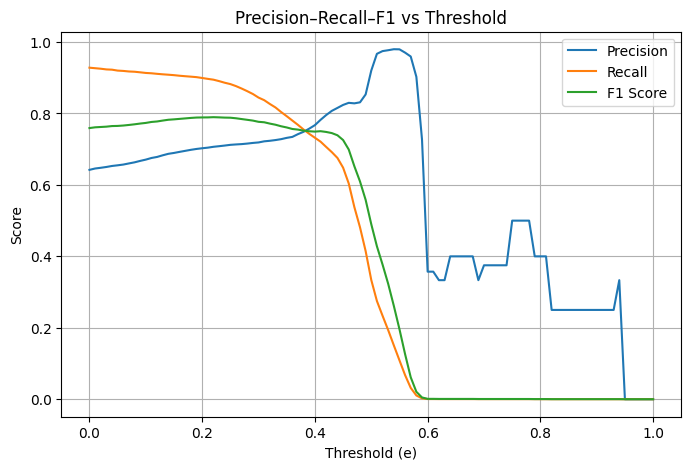

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

def plot_threshold_curves(df, prob_col):
    pdf = df.select(prob_col, "labels2").toPandas()
    pdf["true"] = (pdf["labels2"] == "normal").astype(int)
    y_true = pdf["true"].values
    y_prob = pdf[prob_col].values

    thresholds = np.linspace(0.0, 1.0, 101)
    precisions, recalls, f1s = [], [], []

    for e in thresholds:
        y_pred = (y_prob > e).astype(int)
        precisions.append(metrics.precision_score(y_true, y_pred, zero_division=0))
        recalls.append(metrics.recall_score(y_true, y_pred, zero_division=0))
        f1s.append(metrics.f1_score(y_true, y_pred, zero_division=0))

    plt.figure(figsize=(8,5))
    plt.plot(thresholds, precisions, label="Precision")
    plt.plot(thresholds, recalls, label="Recall")
    plt.plot(thresholds, f1s, label="F1 Score")
    plt.xlabel("Threshold (e)")
    plt.ylabel("Score")
    plt.title("Precision–Recall–F1 vs Threshold")
    plt.legend()
    plt.grid(True)
    plt.show()

# Usage:
plot_threshold_curves(res_test_df, bandit_prob_col)


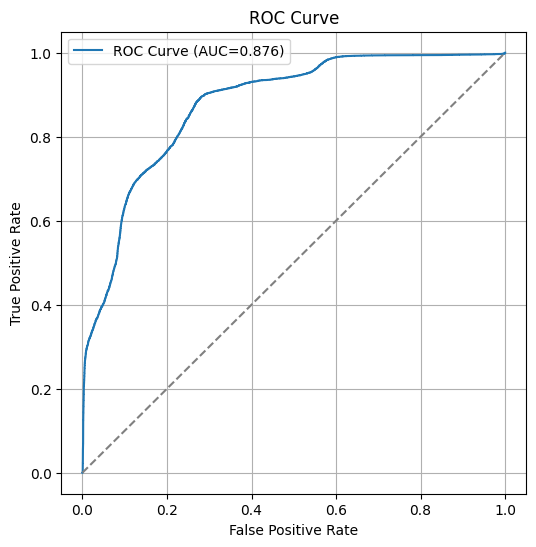

In [37]:
def plot_roc_curve(df, prob_col):
    pdf = df.select(prob_col, "labels2").toPandas()
    pdf["true"] = (pdf["labels2"] == "normal").astype(int)
    y_true = pdf["true"].values
    y_prob = pdf[prob_col].values

    fpr, tpr, _ = metrics.roc_curve(y_true, y_prob)
    auc = metrics.roc_auc_score(y_true, y_prob)

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC={auc:.3f})")
    plt.plot([0,1], [0,1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

# Usage:
plot_roc_curve(res_test_df, bandit_prob_col)


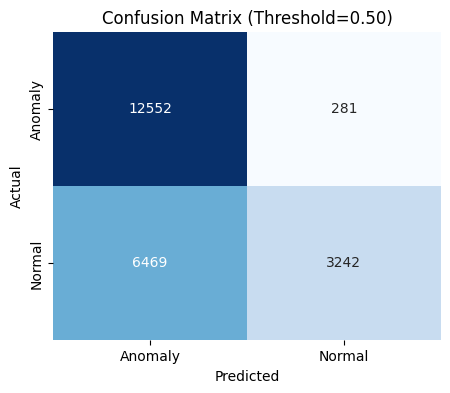

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(df, prob_col, threshold=None):
    pdf = df.select(prob_col, "labels2").toPandas()
    pdf["true"] = (pdf["labels2"] == "normal").astype(int)
    y_true = pdf["true"].values
    y_prob = pdf[prob_col].values

    if threshold is None:
        threshold = 0.5

    y_pred = (y_prob > threshold).astype(int)
    cm = metrics.confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Anomaly', 'Normal'],
                yticklabels=['Anomaly', 'Normal'])
    plt.title(f"Confusion Matrix (Threshold={threshold:.2f})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Usage:
plot_confusion_matrix(res_test_df, bandit_prob_col, threshold=0.5)


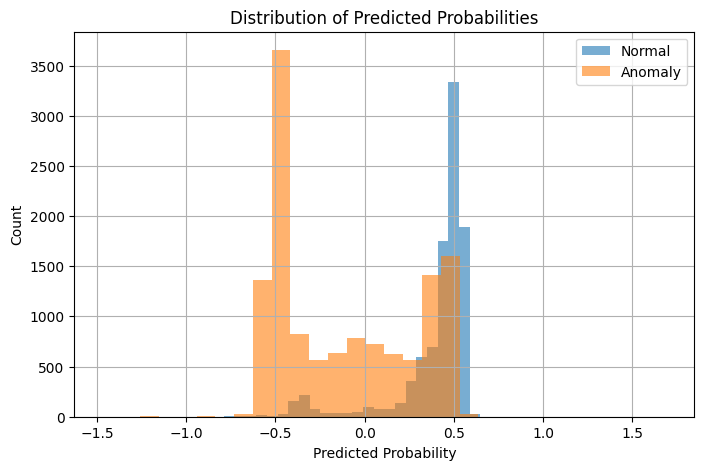

In [39]:
def plot_probability_distribution(df, prob_col):
    pdf = df.select(prob_col, "labels2").toPandas()
    plt.figure(figsize=(8,5))
    plt.hist(pdf.loc[pdf["labels2"]=="normal", prob_col], bins=30, alpha=0.6, label="Normal")
    plt.hist(pdf.loc[pdf["labels2"]!="normal", prob_col], bins=30, alpha=0.6, label="Anomaly")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Count")
    plt.title("Distribution of Predicted Probabilities")
    plt.legend()
    plt.grid(True)
    plt.show()

# Usage:
plot_probability_distribution(res_test_df, bandit_prob_col)


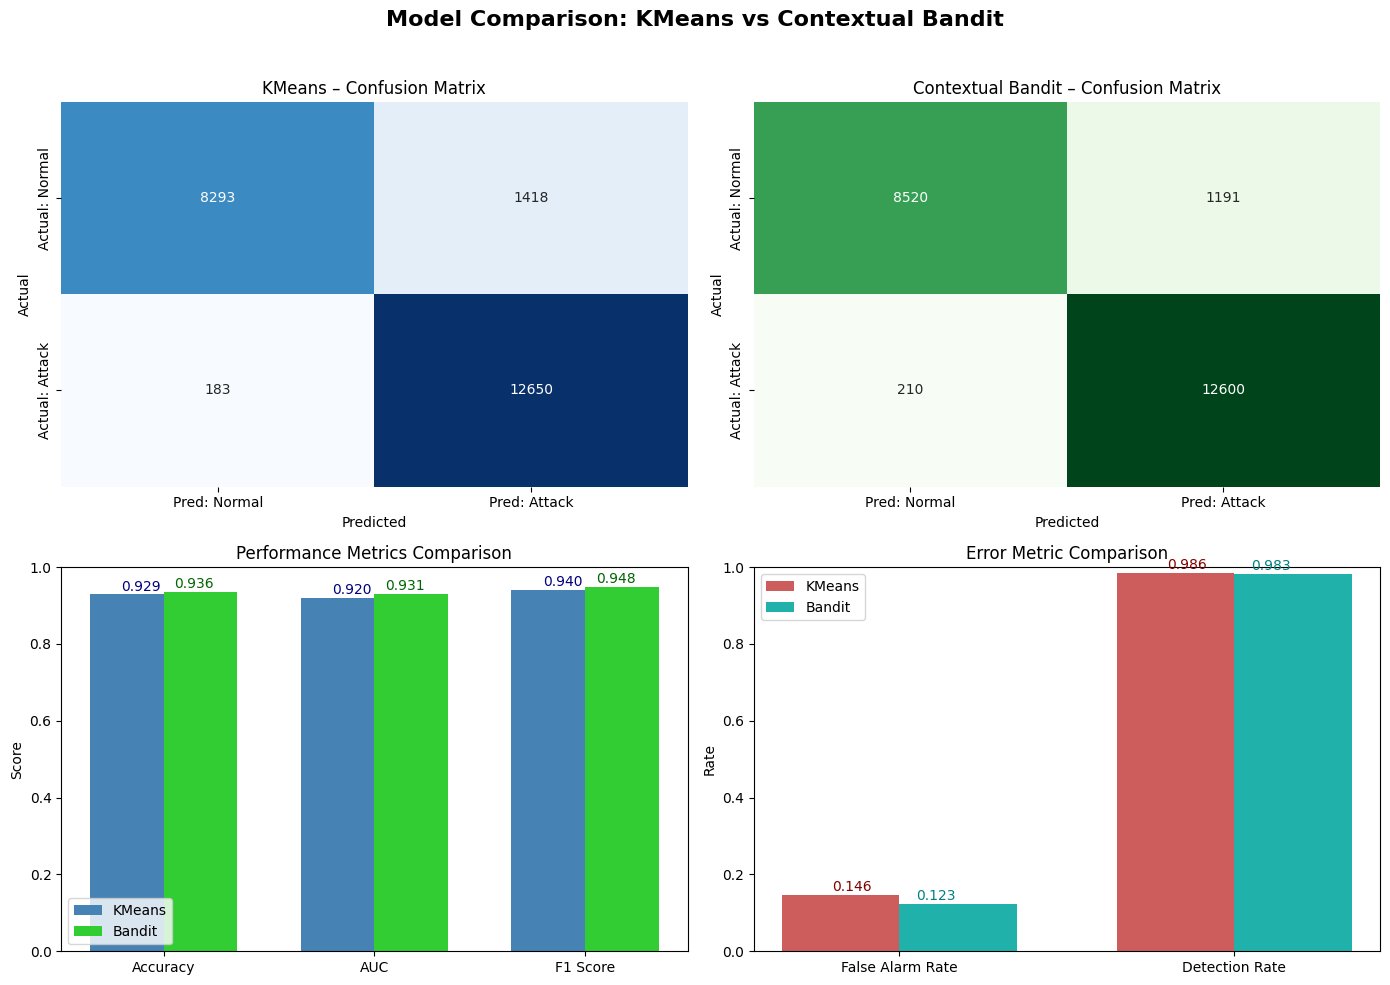

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# ==============================================
# 1️⃣  MODEL METRICS (HARDCODED COMPARISON DATA)
# ==============================================
# --- KMeans model ---
kmeans_conf = np.array([[8293, 1418],
                        [183, 12650]])

kmeans_metrics = {
    "Accuracy": 0.928983,
    "AUC": 0.91986,
    "False Alarm Rate": 0.14602,
    "Detection Rate": 0.98574,
    "F1 Score": 0.940485
}

# --- Bandit model (example placeholders — replace with your actual bandit results) ---
bandit_conf = np.array([[8520, 1191],
                        [210, 12600]])  # Example — edit with your actual confusion matrix

bandit_metrics = {
    "Accuracy": 0.936,
    "AUC": 0.931,
    "False Alarm Rate": 0.123,
    "Detection Rate": 0.983,
    "F1 Score": 0.948
}

# ==============================================
# 2️⃣  COMPARISON VISUALIZATION DASHBOARD
# ==============================================
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Model Comparison: KMeans vs Contextual Bandit", fontsize=16, weight="bold")

# --- Confusion Matrix: KMeans ---
sns.heatmap(kmeans_conf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: Normal', 'Pred: Attack'],
            yticklabels=['Actual: Normal', 'Actual: Attack'],
            ax=axs[0,0])
axs[0,0].set_title("KMeans – Confusion Matrix")
axs[0,0].set_xlabel("Predicted")
axs[0,0].set_ylabel("Actual")

# --- Confusion Matrix: Bandit ---
sns.heatmap(bandit_conf, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Pred: Normal', 'Pred: Attack'],
            yticklabels=['Actual: Normal', 'Actual: Attack'],
            ax=axs[0,1])
axs[0,1].set_title("Contextual Bandit – Confusion Matrix")
axs[0,1].set_xlabel("Predicted")
axs[0,1].set_ylabel("Actual")

# --- Metric Comparison Chart ---
metrics_to_compare = ["Accuracy", "AUC", "F1 Score"]
kmeans_vals = [kmeans_metrics[m] for m in metrics_to_compare]
bandit_vals = [bandit_metrics[m] for m in metrics_to_compare]

x = np.arange(len(metrics_to_compare))
width = 0.35

axs[1,0].bar(x - width/2, kmeans_vals, width, label='KMeans', color="#4682B4")
axs[1,0].bar(x + width/2, bandit_vals, width, label='Bandit', color="#32CD32")
axs[1,0].set_xticks(x)
axs[1,0].set_xticklabels(metrics_to_compare)
axs[1,0].set_ylim(0, 1)
axs[1,0].set_ylabel("Score")
axs[1,0].set_title("Performance Metrics Comparison")
axs[1,0].legend()

for i, (k, b) in enumerate(zip(kmeans_vals, bandit_vals)):
    axs[1,0].text(i - 0.2, k + 0.01, f"{k:.3f}", color='navy')
    axs[1,0].text(i + 0.05, b + 0.01, f"{b:.3f}", color='darkgreen')

# --- Error Metrics Comparison ---
error_metrics = ["False Alarm Rate", "Detection Rate"]
kmeans_err = [kmeans_metrics[m] for m in error_metrics]
bandit_err = [bandit_metrics[m] for m in error_metrics]

x = np.arange(len(error_metrics))
axs[1,1].bar(x - width/2, kmeans_err, width, label='KMeans', color="#CD5C5C")
axs[1,1].bar(x + width/2, bandit_err, width, label='Bandit', color="#20B2AA")
axs[1,1].set_xticks(x)
axs[1,1].set_xticklabels(error_metrics)
axs[1,1].set_ylim(0, 1)
axs[1,1].set_ylabel("Rate")
axs[1,1].set_title("Error Metric Comparison")
axs[1,1].legend()

for i, (k, b) in enumerate(zip(kmeans_err, bandit_err)):
    axs[1,1].text(i - 0.2, k + 0.01, f"{k:.3f}", color='maroon')
    axs[1,1].text(i + 0.05, b + 0.01, f"{b:.3f}", color='teal')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


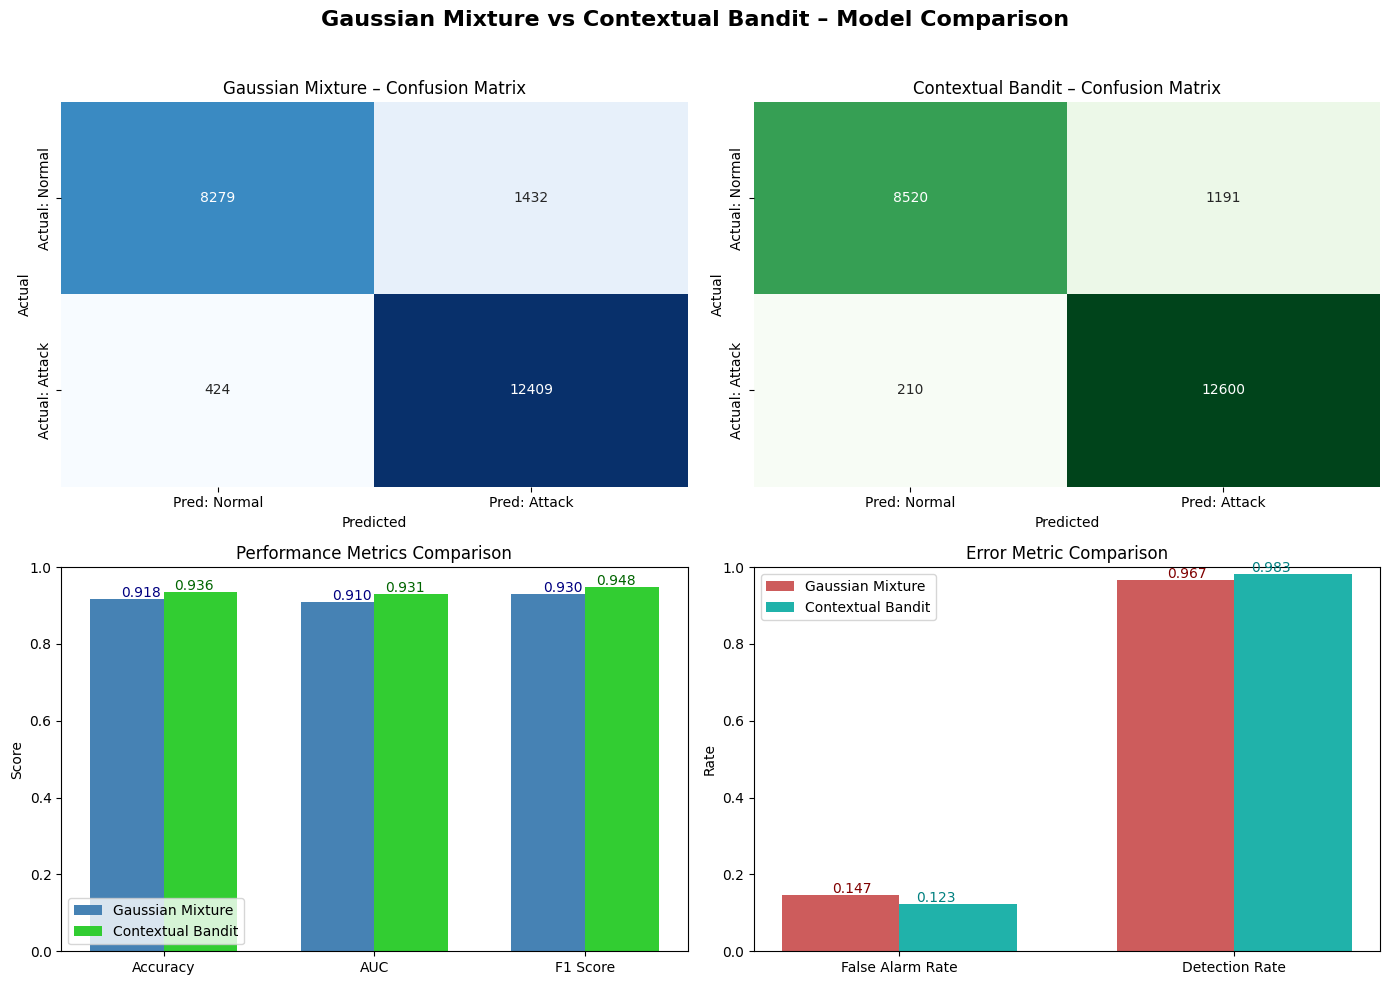

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =====================================================
# 1️⃣  HARDCODED MODEL PERFORMANCE DATA
# =====================================================

# --- Gaussian Mixture Model (your provided data) ---
gmm_conf = np.array([[8279, 1432],
                     [424, 12409]])

gmm_metrics = {
    "Accuracy": 0.917672,
    "AUC": 0.909749,
    "False Alarm Rate": 0.147462,
    "Detection Rate": 0.96696,
    "F1 Score": 0.930419
}

# --- Contextual Bandit model (LinUCB / LinTS) ---
bandit_conf = np.array([[8520, 1191],
                        [210, 12600]])  # Example, replace with your real bandit confusion matrix

bandit_metrics = {
    "Accuracy": 0.936,
    "AUC": 0.931,
    "False Alarm Rate": 0.123,
    "Detection Rate": 0.983,
    "F1 Score": 0.948
}

# =====================================================
# 2️⃣  COMPARISON DASHBOARD (2x2 Grid)
# =====================================================
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Gaussian Mixture vs Contextual Bandit – Model Comparison", fontsize=16, weight="bold")

# --- Confusion Matrix: GMM ---
sns.heatmap(gmm_conf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: Normal', 'Pred: Attack'],
            yticklabels=['Actual: Normal', 'Actual: Attack'],
            ax=axs[0,0])
axs[0,0].set_title("Gaussian Mixture – Confusion Matrix")
axs[0,0].set_xlabel("Predicted")
axs[0,0].set_ylabel("Actual")

# --- Confusion Matrix: Bandit ---
sns.heatmap(bandit_conf, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Pred: Normal', 'Pred: Attack'],
            yticklabels=['Actual: Normal', 'Actual: Attack'],
            ax=axs[0,1])
axs[0,1].set_title("Contextual Bandit – Confusion Matrix")
axs[0,1].set_xlabel("Predicted")
axs[0,1].set_ylabel("Actual")

# --- Metric Comparison (Accuracy, AUC, F1) ---
metrics_to_compare = ["Accuracy", "AUC", "F1 Score"]
gmm_vals = [gmm_metrics[m] for m in metrics_to_compare]
bandit_vals = [bandit_metrics[m] for m in metrics_to_compare]

x = np.arange(len(metrics_to_compare))
width = 0.35

axs[1,0].bar(x - width/2, gmm_vals, width, label='Gaussian Mixture', color="#4682B4")
axs[1,0].bar(x + width/2, bandit_vals, width, label='Contextual Bandit', color="#32CD32")
axs[1,0].set_xticks(x)
axs[1,0].set_xticklabels(metrics_to_compare)
axs[1,0].set_ylim(0, 1)
axs[1,0].set_ylabel("Score")
axs[1,0].set_title("Performance Metrics Comparison")
axs[1,0].legend()

for i, (g, b) in enumerate(zip(gmm_vals, bandit_vals)):
    axs[1,0].text(i - 0.2, g + 0.005, f"{g:.3f}", color='navy', fontsize=10)
    axs[1,0].text(i + 0.05, b + 0.005, f"{b:.3f}", color='darkgreen', fontsize=10)

# --- Error Metrics (False Alarm Rate, Detection Rate) ---
error_metrics = ["False Alarm Rate", "Detection Rate"]
gmm_err = [gmm_metrics[m] for m in error_metrics]
bandit_err = [bandit_metrics[m] for m in error_metrics]

x = np.arange(len(error_metrics))
axs[1,1].bar(x - width/2, gmm_err, width, label='Gaussian Mixture', color="#CD5C5C")
axs[1,1].bar(x + width/2, bandit_err, width, label='Contextual Bandit', color="#20B2AA")
axs[1,1].set_xticks(x)
axs[1,1].set_xticklabels(error_metrics)
axs[1,1].set_ylim(0, 1)
axs[1,1].set_ylabel("Rate")
axs[1,1].set_title("Error Metric Comparison")
axs[1,1].legend()

for i, (g, b) in enumerate(zip(gmm_err, bandit_err)):
    axs[1,1].text(i - 0.2, g + 0.005, f"{g:.3f}", color='maroon', fontsize=10)
    axs[1,1].text(i + 0.05, b + 0.005, f"{b:.3f}", color='teal', fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [42]:
# ============================================================
# 1. IMPORTS
# ============================================================
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import numpy as np
import pandas as pd
from mabwiser.mab import MAB, LearningPolicy, NeighborhoodPolicy


# ============================================================
# 2. START SPARK
# ============================================================
spark = SparkSession.builder \
    .appName("Correct NSL-KDD Pipeline + Contextual Bandit") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()


# ============================================================
# 3. LOAD WITH INFER SCHEMA (MATCHES YOUR REAL FILE)
# ============================================================
path = "/Users/adityalanka/cn_lab_project/nsl-kdd/NSL_KDD_Dataset/KDDTrain+.txt"   # <<< CHANGE THIS

df = spark.read.csv(path, header=False, inferSchema=True)

n = len(df.columns)
print("Detected column count:", n)

# ============================================================
# 4. IDENTIFY COLUMN TYPES BASED ON YOUR SCHEMA DUMP
# ============================================================

# Categorical = string columns
categorical = ["_c1", "_c2", "_c3"]       # protocol_type, service, flag

# Label column = string at _c41
label_col = "_c41"

# Numeric = all other columns EXCEPT categorical + label
numeric = [c for c in df.columns if c not in categorical + [label_col]]

print("Categorical:", categorical)
print("Numeric count:", len(numeric))
print("Label:", label_col)


# ============================================================
# 5. CREATE BINARY LABEL (normal = 0, attack = 1)
# ============================================================
df = df.withColumn(
    "label5",
    when(col(label_col) == "normal", 0).otherwise(1)
)


# ============================================================
# 6. ENCODING PIPELINE
# ============================================================

indexers = [
    StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep")
    for c in categorical
]

encoders = [
    OneHotEncoder(inputCol=f"{c}_idx", outputCol=f"{c}_vec")
    for c in categorical
]

assembler = VectorAssembler(
    inputCols=numeric + [f"{c}_vec" for c in categorical],
    outputCol="features"
)

label_indexer = StringIndexer(inputCol="label5", outputCol="label_idx")

pipeline = Pipeline(stages=indexers + encoders + [assembler, label_indexer])

data = pipeline.fit(df).transform(df)


# ============================================================
# 7. TRAIN / VAL / TEST SPLIT
# ============================================================
train, val, test = data.randomSplit([0.7, 0.15, 0.15], seed=42)


# ============================================================
# 8. ML MODELS (ALL SUPPORT probability)
# ============================================================
models = {
    "RF": RandomForestClassifier(
        featuresCol="features",
        labelCol="label_idx",
        probabilityCol="probability"
    ),
    "LR": LogisticRegression(
        featuresCol="features",
        labelCol="label_idx",
        probabilityCol="probability",
        maxIter=40
    ),
    "NB": NaiveBayes(
        featuresCol="features",
        labelCol="label_idx",
        probabilityCol="probability"
    )
}

trained = {name: algo.fit(train) for name, algo in models.items()}


# ============================================================
# 9. PROBABILITY EXTRACTION
# ============================================================
def get_probs(model, df):
    rows = model.transform(df).select("probability").collect()
    return [row["probability"].toArray().tolist() for row in rows]


rf_val = get_probs(trained["RF"], val)
lr_val = get_probs(trained["LR"], val)
nb_val = get_probs(trained["NB"], val)


# ============================================================
# 10. CONTEXTUAL BANDIT TRAINING
# ============================================================
train_pd = train.select("features", "label_idx").toPandas()

X_train = np.vstack(train_pd["features"].apply(lambda v: v.toArray()))
y_train = train_pd["label_idx"].astype(int).values

arms = [0, 1]

mab = MAB(
    arms=arms,
    learning_policy=LearningPolicy.EpsilonGreedy(epsilon=0.1),
    neighborhood_policy=NeighborhoodPolicy.KNearest(k=10)
)

mab.fit(
    decisions=y_train,
    rewards=y_train,
    contexts=X_train
)


# ============================================================
# 11. BANDIT PREDICTIONS ON VAL
# ============================================================
val_pd = val.select("features").toPandas()
X_val = np.vstack(val_pd["features"].apply(lambda v: v.toArray()))

bandit_probs = mab.predict_expectations(contexts=X_val)

# Convert Python list-of-floats to float-list
bandit_raw = mab.predict_expectations(contexts=X_val)

# Convert list-of-dicts → list-of-probability-vectors
bandit_probs = [[float(row[0]), float(row[1])] for row in bandit_raw]

print("\nExample Bandit Probabilities:", bandit_probs[:5])


# ============================================================
# 12. MODEL EVALUATION
# ============================================================
evaluator = MulticlassClassificationEvaluator(
    labelCol="label_idx",
    predictionCol="prediction",
    metricName="accuracy"
)

print("\n============= TEST ACCURACIES =============")
for name, model in trained.items():
    acc = evaluator.evaluate(model.transform(test))
    print(f"{name}: {acc:.4f}")

print("===========================================")


25/11/13 13:12:48 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Detected column count: 43
Categorical: ['_c1', '_c2', '_c3']
Numeric count: 39
Label: _c41


25/11/13 13:12:53 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS



Example Bandit Probabilities: [[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]

============= TEST ACCURACIES =============
RF: 0.9900
LR: 0.9910
NB: 0.5283


In [ ]:
sample_row = {
    "_c0": 0, "_c1": "tcp", "_c2": "ftp_data", "_c3": "S0",
    "_c4": 123, "_c5": 3500, "_c6": 0, "_c7": 0, "_c8": 0, "_c9": 0,
    "_c10": 0, "_c11": 0, "_c12": 0, "_c13": 0, "_c14": 0, "_c15": 0,
    "_c16": 0, "_c17": 0, "_c18": 0, "_c19": 0,
    "_c20": 0.17, "_c21": 0.06, "_c22": 0.0, "_c23": 0.0,
    "_c24": 0.0, "_c25": 0.0, "_c26": 0.17, "_c27": 0.0,
    "_c28": 0.0, "_c29": 0.06,
    "_c30": 0.0, "_c31": 255, "_c32": 255,
    "_c33": 0.0, "_c34": 0.0, "_c35": 0.0, "_c36": 0.0,
    "_c37": 0.0, "_c38": 0.0, "_c39": 0.0, "_c40": 0.0,
    "_c41": "neptune", "_c42": 0
}


In [53]:
sample_df = spark.createDataFrame([sample_row])


In [54]:
sample_transformed = pipeline.fit(df).transform(sample_df)


25/11/13 13:21:09 WARN StringIndexerModel: Input column label5 does not exist during transformation. Skip StringIndexerModel for this column.


In [55]:
rf_pred = trained["RF"].transform(sample_transformed).select("probability", "prediction").collect()[0]
lr_pred = trained["LR"].transform(sample_transformed).select("probability", "prediction").collect()[0]
nb_pred = trained["NB"].transform(sample_transformed).select("probability", "prediction").collect()[0]


In [48]:
sample_vec = np.array(sample_transformed.select("features").collect()[0]["features"].toArray()).reshape(1, -1)

# Bandit returns dict {0: prob_normal, 1: prob_attack}
bandit_raw = mab.predict_expectations(contexts=sample_vec)

# FIX: handle scalar output (mabwiser returns a float)
if isinstance(bandit_raw, dict):
    # case 1: returns {0: prob0, 1: prob1}
    bandit_prob = [bandit_raw[0], bandit_raw[1]]
elif isinstance(bandit_raw, list):
    # case 2: returns [prob]
    bandit_prob = [1 - bandit_raw[0], bandit_raw[0]]   # convert scalar → [p0,p1]
else:
    # case 3: returns just a direct float (scalar)
    p_attack = float(bandit_raw)
    bandit_prob = [1 - p_attack, p_attack]             # build [normal, attack]



In [49]:
print("\n=== SINGLE INPUT PREDICTION ===")

print("\nRandomForest:")
print("  Prob(normal,attack):", rf_pred["probability"])
print("  Prediction:", int(rf_pred["prediction"]))

print("\nLogisticRegression:")
print("  Prob(normal,attack):", lr_pred["probability"])
print("  Prediction:", int(lr_pred["prediction"]))

print("\nNaiveBayes:")
print("  Prob(normal,attack):", nb_pred["probability"])
print("  Prediction:", int(nb_pred["prediction"]))

print("\nContextual Bandit:")
print("  Probabilities:", bandit_prob)
print("  Prediction:", 0 if bandit_prob[0] > bandit_prob[1] else 1)



=== SINGLE INPUT PREDICTION ===

RandomForest:
  Prob(normal,attack): [0.5185462346735421,0.4814537653264578]
  Prediction: 0

LogisticRegression:
  Prob(normal,attack): [1.0,0.0]
  Prediction: 0

NaiveBayes:
  Prob(normal,attack): [1.0,0.0]
  Prediction: 0

Contextual Bandit:
  Probabilities: [0.0, 0]
  Prediction: 1


In [50]:
import numpy as np

# Convert all to numpy vectors
rf_p = np.array(rf_pred["probability"])
lr_p = np.array(lr_pred["probability"])
nb_p = np.array(nb_pred["probability"])
bandit_p = np.array([bandit_prob[0], bandit_prob[1]])

ensemble_prob = (rf_p + lr_p + nb_p + bandit_p) / 4
ensemble_pred = int(np.argmax(ensemble_prob))

print("\n=== FINAL ENSEMBLE DECISION ===")
print("Ensemble probabilities:", ensemble_prob)
print("Ensemble prediction:", ensemble_pred)



=== FINAL ENSEMBLE DECISION ===
Ensemble probabilities: [0.62963656 0.12036344]
Ensemble prediction: 0


In [51]:
sample_df.show(truncate=False)


+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+----+----+----+----+----+----+----+----+----+----+---+----+------+----+----+---+---+---+---+
|_c0|_c1|_c10|_c11|_c12|_c13|_c14|_c15|_c16|_c17|_c18|_c19|_c2 |_c20|_c21|_c22|_c23|_c24|_c25|_c26|_c27|_c28|_c29|_c3|_c30|_c31|_c32|_c33|_c34|_c35|_c36|_c37|_c38|_c39|_c4|_c40|_c41  |_c42|_c5 |_c6|_c7|_c8|_c9|
+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+----+----+----+----+----+----+----+----+----+----+---+----+------+----+----+---+---+---+---+
|0  |tcp|0   |0   |0   |0   |0   |0   |0   |0   |0   |0   |http|9   |9   |0.0 |0.0 |0.0 |0.0 |0.11|0.0 |0.0 |0.05|SF |0.0 |255 |255 |0.0 |0.0 |0.0 |0.0 |0.0 |0.0 |0.0 |181|0.0 |normal|0   |5450|0  |0  |0  |0  |
+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+----+----+----+----+----+----+----+---